# Tensorflow and Keras model
## Imports and version check

In [31]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import Image

print(tf.__version__)
print(tf.test.is_built_with_cuda())

2.6.0
True


## Configuration

In [32]:
plt.style.use("ggplot")
np.set_printoptions(precision=3, suppress=True)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read CSV file

In [116]:
# current_path = os.path.dirname(os.path.realpath(__file__))
current_path = os.path.abspath('')
training_data_path = os.path.abspath(os.path.join(current_path, '..', '..', 'data', 'TRAINING_DATA.csv'))
csv_data = pd.read_csv(training_data_path)
csv_data.iloc[:5,[0,31]]

,1,32
0,8,3
1,6,3
2,4,3
3,4,8
4,7,2


## Split data into train and test

In [117]:
dataset = csv_data.copy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1,8000.0,5.019000,2.581370,1.000000,3.000000,5.000000,7.000000,9.000000
2,8000.0,4.980500,2.573072,1.000000,3.000000,5.000000,7.000000,9.000000
3,8000.0,5.006875,2.605701,1.000000,3.000000,5.000000,7.000000,9.000000
4,8000.0,4.984875,2.582195,1.000000,3.000000,5.000000,7.000000,9.000000
5,8000.0,5.011375,2.591010,1.000000,3.000000,5.000000,7.000000,9.000000
...,...,...,...,...,...,...,...,...
keff69,8000.0,0.942628,0.007630,0.907837,0.937509,0.942794,0.947944,0.968298
ppf_start,8000.0,3.233506,0.787582,1.919000,2.721000,3.037000,3.496000,9.917000
ppf_max,8000.0,3.529833,1.259520,1.979000,2.722000,3.087000,3.879250,12.390000
ppf_end,8000.0,1.365294,0.047191,1.238000,1.332000,1.361000,1.394000,1.587000


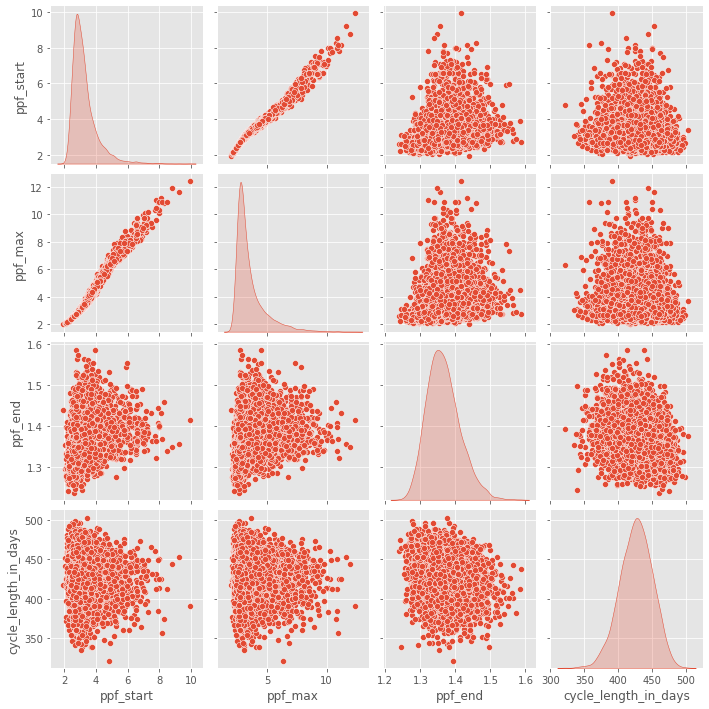

In [118]:
# sns.pairplot(train_dataset[['keff_start', 'keff_max', 'ppf_start', 'cycle_length_in_days']], diag_kind='kde')
sns.pairplot(train_dataset[['ppf_start', 'ppf_max', 'ppf_end', 'cycle_length_in_days']], diag_kind='kde')


## Split features from labels
Separate target values from the values on which the neural network is being trained.

In [119]:
vectors_train = train_dataset.iloc[:, :32].astype('uint8')
cycle_length_train = train_dataset.iloc[:, -1]
vectors_test = test_dataset.iloc[:, :32].astype('uint8')
cycle_length_test = test_dataset.iloc[:, -1]

# train_labels = train_dataset.pop("cycle_length_in_days")
# test_labels = test_dataset.pop("cycle_length_in_days")

## Normalization
Normalization layer normalizes values along rows.

In [120]:
normalizer = layers.Normalization(axis=1, mean=None)
normalizer.adapt(vectors_test)
first = vectors_train.iloc[:1]
print("First row: {} \nNormalized: {}"
      .format(first.to_numpy(), normalizer(first)))

First row: [[1 7 8 2 7 3 8 2 5 3 2 6 7 7 6 7 3 7 5 8 1 5 9 7 1 1 3 2 9 5 8 3]] 
Normalized: [[-1.529  0.769  1.121 -1.121  0.775 -0.744  1.129 -1.187 -0.088 -0.761
  -1.164  0.366  0.75   0.789  0.369  0.78  -0.78   0.777  0.014  1.147
  -1.607  0.007  1.584  0.744 -1.559 -1.54  -0.765 -1.183  1.488  0.028
   1.177 -0.758]]


# Model
## Layers

In [121]:
model = keras.Sequential([
    keras.Input(shape=(32,), dtype='uint8', name="input"),
    normalizer,
    layers.Dense(units=50, activation=keras.activations.gelu),
    layers.Dense(units=30, activation=keras.activations.gelu),
    layers.Dense(units=20, activation=keras.activations.gelu),
    layers.Dense(units=30, activation=keras.activations.gelu),
    layers.Dense(units=50, activation=keras.activations.gelu),
    layers.Dense(units=1, name="output")
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 32)                65        
_________________________________________________________________
dense_51 (Dense)             (None, 50)                1650      
_________________________________________________________________
dense_52 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_53 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_54 (Dense)             (None, 30)                630       
_________________________________________________________________
dense_55 (Dense)             (None, 50)                1550      
_________________________________________________________________
output (Dense)               (None, 1)               

## Compile

In [122]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.1),
    loss = keras.losses.mean_absolute_error,
    metrics=[keras.metrics.mean_absolute_error]
)

## Fit

In [123]:
%%time
history = model.fit(
    vectors_train,
    cycle_length_train,
    epochs = 30,
    verbose = 0,
    validation_data = (vectors_test, cycle_length_test)
)

Wall time: 42 s


In [124]:
# history.history

#### Plot loss and other parameters from history

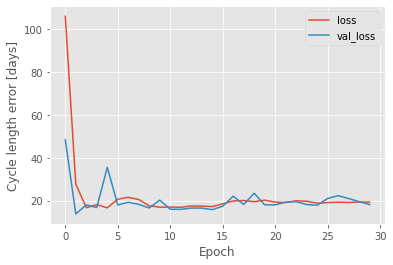

In [125]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Cycle length error [days]')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss.svg')


plot_loss(history)

## Evaluation

In [64]:
results = model.evaluate(vectors_test, cycle_length_test)
print("test loss, test acc:", results)

7/7 [==============================] - 0s 3ms/step - loss: 36.3299 - mean_absolute_error: 36.3299
test loss, test acc: [36.329898834228516, 36.329898834228516]


In [50]:
x = vectors_test.iloc[:2]
print(cycle_length_test.iloc[:2])
y = model.predict(x)
print(y)

9     436.027726
11    427.790123
Name: cycle_length_in_days, dtype: float64
[[448.514]
 [461.653]]
